## Model Training

#### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


In [ ]:
!pip install xgboost

In [2]:
# Install missing libraries
#!pip install catboost xgboost

# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Modelling & Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV

# Extra ML Libraries
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from google.colab import files

#### Import the CSV Data as Pandas DataFrame

In [3]:
uploaded = files.upload()  # This will open a file picker for students to upload the dataset


Saving clean_students_performance3.csv to clean_students_performance3.csv


In [4]:
df = pd.read_csv('clean_students_performance3.csv')

#### Show Top 5 Records

In [5]:
df.head()

,gender,race ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score,average
0,female,group B,bachelor's degree,standard,none,72.0,72,74,218.0,72.666667
1,female,group C,some college,standard,completed,69.0,90,88,247.0,82.333333
2,female,group B,master's degree,standard,none,90.0,95,93,278.0,92.666667
3,male,group A,associate's degree,free/reduced,none,47.0,57,44,148.0,49.333333
4,male,group C,some college,standard,none,76.0,78,75,229.0,76.333333


In [6]:
# Remove 'total score' and 'average' columns
df = df.drop(columns=["total score", "average"])

In [7]:
df.shape

(1000, 8)

In [ ]:
#df.columns = df.columns.str.replace("_", " ")


#### Preparing X and Y variables

In [9]:
X = df.drop(columns=['math score'],axis=1)

In [10]:
X.head()

,gender,race ethnicity,parental level of education,lunch,test preparation course,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [11]:
print("Categories in 'gender' variable:     ",end=" " )
print(df['gender'].unique())

print("Categories in 'race_ethnicity' variable:  ",end=" ")
print(df['race ethnicity'].unique())

print("Categories in'parental level of education' variable:",end=" " )
print(df['parental level of education'].unique())

print("Categories in 'lunch' variable:     ",end=" " )
print(df['lunch'].unique())

print("Categories in 'test preparation course' variable:     ",end=" " )
print(df['test preparation course'].unique())

Categories in 'gender' variable:      ['female' 'male']
Categories in 'race_ethnicity' variable:   ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in'parental level of education' variable: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in 'lunch' variable:      ['standard' 'free/reduced']
Categories in 'test preparation course' variable:      ['none' 'completed']


In [12]:
y = df['math score']

In [13]:
y

,math score
0,72.0
1,69.0
2,90.0
3,47.0
4,76.0
...,...
995,88.0
996,62.0
997,59.0
998,68.0


### StandardScaler (ST)

$$
z = \frac{x - \mu}{\sigma}
$$

- \( x \) = original feature value  
- \( \mu \) = mean of the feature  
- \( \sigma \) = standard deviation of the feature  
- \( z \) = standardized value (now mean = 0, std = 1)  

---

### OneHotEncoder (OHE)

For a categorical feature with \( n \) categories:  

$$
\text{Category } i \;\; \rightarrow \;\; [0, 0, \dots, 1, \dots, 0]
$$  

**Example (Gender):**  

$$
\text{Male} \;\; \rightarrow [1, 0], \quad \text{Female} \;\; \rightarrow [0, 1]
$$


### OneHotEncoder Example

| Color | Red | Green | Blue |
|-------|-----|-------|------|
| Red   |  1  |   0   |   0  |
| Green |  0  |   1   |   0  |
| Blue  |  0  |   0   |   1  |

**Formula:**

$$
\text{Category } i \;\; \rightarrow \;\; [0,0,\dots,1,\dots,0]
$$


In [14]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),
    ]
)

In [15]:
X = preprocessor.fit_transform(X)

In [17]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)
X_train.shape, X_test.shape

((800, 19), (200, 19))

#### Create an Evaluate Function to give all metrics after model Training

In [18]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

### Machine Learning Models Used

#### Linear Regression
$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_n x_n + \epsilon
$$  
[📘 Learn more](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares)

---

#### Lasso Regression
$$
\text{Cost} = \sum (y_i - \hat{y}_i)^2 + \lambda \sum |\beta_j|
$$  
[📘 Learn more](https://scikit-learn.org/stable/modules/linear_model.html#lasso)

---

#### Ridge Regression
$$
\text{Cost} = \sum (y_i - \hat{y}_i)^2 + \lambda \sum \beta_j^2
$$  
[📘 Learn more](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression)

---

#### K-Neighbors Regressor
$$
\hat{y} = \frac{1}{k} \sum_{i \in N_k(x)} y_i
$$  
[📘 Learn more](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-regression)

---

#### Decision Tree Regressor
Splits data using conditions that minimize impurity (e.g., MSE).  
[📘 Learn more](https://scikit-learn.org/stable/modules/tree.html#regression)

---

#### Random Forest Regressor
$$
\hat{y} = \frac{1}{T} \sum_{t=1}^T h_t(x)
$$  
(average prediction of many decision trees)  
[📘 Learn more](https://scikit-learn.org/stable/modules/ensemble.html#random-forests)

---

#### XGBRegressor
Gradient boosting on decision trees with regularization.  
[📘 Learn more](https://xgboost.readthedocs.io/en/stable/)

---

#### CatBoost Regressor
Gradient boosting with efficient handling of categorical features.  
[📘 Learn more](https://catboost.ai/en/docs/)

---

#### AdaBoost Regressor
$$
F(x) = \sum_{m=1}^M \alpha_m h_m(x)
$$  
(ensemble of weak learners with weighted votes)  
[📘 Learn more](https://scikit-learn.org/stable/modules/ensemble.html#adaboost)


In [19]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)


    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')

    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)

    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.5461
- Mean Absolute Error: 4.3132
- R2 Score: 0.8618
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.4212
- Mean Absolute Error: 4.2320
- R2 Score: 0.8791


Lasso
Model performance for Training set
- Root Mean Squared Error: 6.7760
- Mean Absolute Error: 5.3007
- R2 Score: 0.7937
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.6375
- Mean Absolute Error: 5.2658
- R2 Score: 0.8187


Ridge
Model performance for Training set
- Root Mean Squared Error: 5.5464
- Mean Absolute Error: 4.3115
- R2 Score: 0.8617
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.4188
- Mean Absolute Error: 4.2283
- R2 Score: 0.8792


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 5.8757
- Mean Absolute Error: 4.5747
- R2 Score: 0.8448
-----------------------

### Results

In [20]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
2,Ridge,0.879190
0,Linear Regression,0.879081
7,CatBoosting Regressor,0.837402
5,Random Forest Regressor,0.834569
1,Lasso,0.818739
8,AdaBoost Regressor,0.818174
6,XGBRegressor,0.788574
3,K-Neighbors Regressor,0.766054
4,Decision Tree,0.730629


## Linear Regression

In [21]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 87.91


## Plot y_pred and y_test

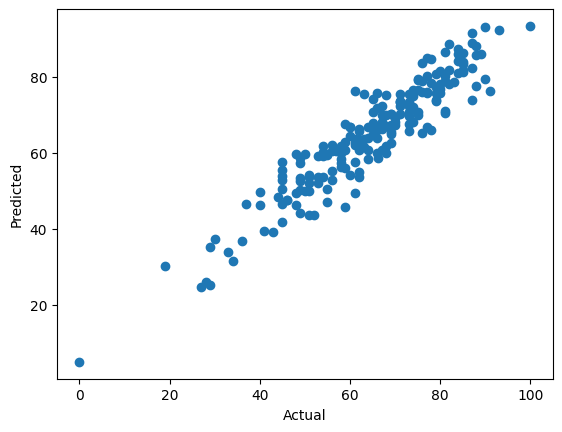

In [22]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

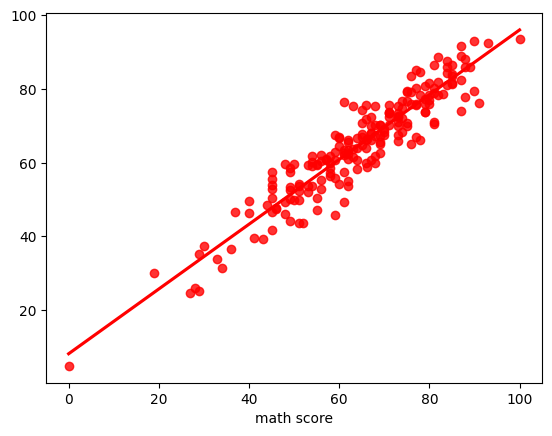

In [23]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

#### Difference between Actual and Predicted Values

In [24]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91.0,76.224166,14.775834
737,53.0,59.215698,-6.215698
740,80.0,76.832602,3.167398
660,74.0,76.675642,-2.675642
411,84.0,87.406626,-3.406626
...,...,...,...
408,52.0,43.623870,8.376130
332,62.0,62.241162,-0.241162
208,74.0,68.160411,5.839589
613,65.0,66.982632,-1.982632


# It’s an ensemble model called a VotingRegressor.
# Instead of relying on a single model, it trains several regressors (Linear Regression, Decision Tree, KNN) on the same training data and then averages their predictions to get the final prediction.

In [25]:
# import necessary libraries
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# define individual models
model1 = LinearRegression()
model2 = DecisionTreeRegressor()
model3 = KNeighborsRegressor()

# define the ensemble model
ensemble_model = VotingRegressor([('lr', model1), ('dt', model2), ('knn', model3)])

# fit the ensemble model on the training data
ensemble_model.fit(X_train, y_train)

# predict on the test data
y_pred = ensemble_model.predict(X_test)


In [26]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91.0,79.874722,11.125278
737,53.0,58.338566,-5.338566
740,80.0,76.744201,3.255799
660,74.0,74.958547,-0.958547
411,84.0,80.802209,3.197791
...,...,...,...
408,52.0,48.207957,3.792043
332,62.0,64.747054,-2.747054
208,74.0,69.586804,4.413196
613,65.0,66.794211,-1.794211


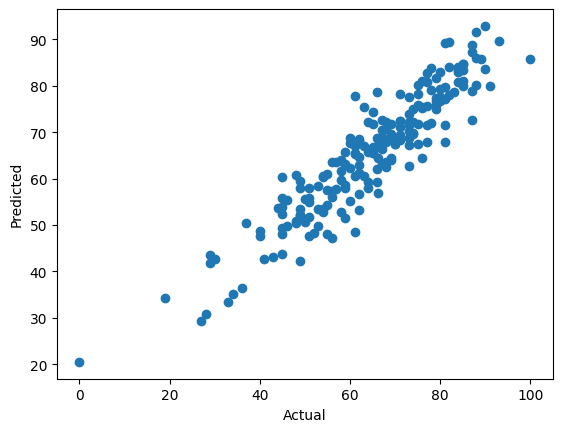

In [28]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

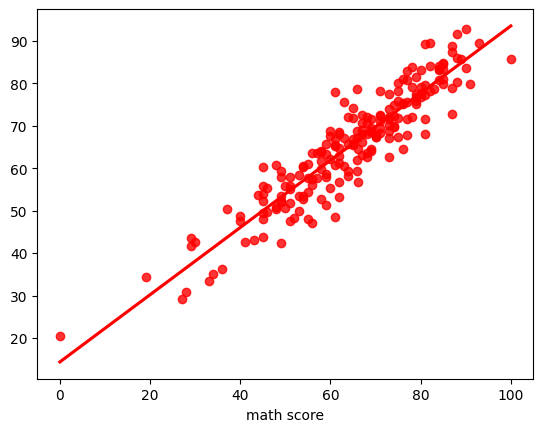

In [29]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');